In [1]:
!pip install opencv-python


     |████████████████████████████████| 49.5 MB 58 kB/s s eta 0:00:01


In [1]:
%load_ext autoreload
%autoreload 2
import img_text_composition_models
from enum import Enum
import datasets
import torchvision
import torch
from main import load_dataset, create_model_and_optimizer
import test_retrieval
from tqdm import tqdm
import cv2
from utils.FilePickling import pkl_save, pkl_load
import numpy as np
from torch.nn import MSELoss
from collections import OrderedDict
from torch.optim import SGD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class opt_config:
    def __init__(self):
        self.dataset = "css3d"
        self.dataset_path = "../data/CSSDataset/CSS-vn-vanilla-v2.json" 
        self.model = "tirg" 
        self.loss = "soft_triplet" 
        self.comment = "css3d_tirg"
        self.embed_dim = 512
        self.learning_rate = 1e-2
        self.weight_decay = 1e-6 
        self.f = ""
        self.learning_rate_decay_frequency = 99999999
        self.batch_size = 32
        self.num_epochs = 100
        self.n_epochs_valudations = 5
        self.loader_num_workers = 4
        self.pretrained_weights = "runs/Sep23_05-38-54_ai-servers-3css_vn_vanilla_v2/latest_checkpoint.pth"
        
opt = opt_config()

trainset, testset = load_dataset(opt)
texts = [t for t in trainset.get_all_texts()]
model = img_text_composition_models.TIRG(texts, embed_dim=opt.embed_dim)

Reading dataset  css3d
trainset size: 19012
testset size: 19057


# Visualization 

- imgs là tensor `[batch_size, 3,120,180]`
- texts là list str len `batch_size`

In [3]:
import matplotlib.pyplot as plt

chosen_idx = 5

# Plot query
true_idx = img_ids[chosen_idx]
idx_fill = str(true_idx).zfill(6)
img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
plt.imshow(img)
mod = mods[chosen_idx]
plt.title(mod)

# Plot output
plt.figure(figsize=(20,10))
plt.axis('off')
width = 4
height = 4
for i in range(width*height):
    plt.subplot(width,height,i+1)
    plt.xticks([])
    plt.yticks([])
    idx = str(nn_result[chosen_idx][i])
    idx_fill = idx.zfill(6)
    img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
    plt.imshow(img)
    
    if idx == all_target_captions[chosen_idx]:
        plt.title("GT")

NameError: name 'img_ids' is not defined

# Reconstruction
To perform reconstruction, one needs:
- Image + text
- Its representation in TIRG


In [8]:
all_imgs = pkl_load("pkl/all_imgs.pkl")
all_captions = pkl_load("pkl/all_captions.pkl")
img_ids = pkl_load("pkl/img_ids.pkl")
mods = pkl_load("pkl/mods.pkl")
nn_result = pkl_load("pkl/nn_result.pkl")
all_target_captions = pkl_load("pkl/all_target_captions.pkl")

In [17]:
from img_text_composition_models import TIRGReconstructionModel

In [18]:
rec_model = TIRGReconstructionModel(model, embed_dim=512, img_shape = [3,120,180]).cuda()

In [19]:
trainloader = trainset.get_loader(
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=opt.loader_num_workers)
testloader = testset.get_loader(
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=opt.loader_num_workers)

In [20]:
criteria =  MSELoss(reduction = 'mean')
n_batches = len(trainloader)
n_epochs = 100


optimizer = torch.optim.SGD(rec_model.parameters(), lr=0.01, momentum=0.9)

progressbar = tqdm(
            range(n_batches),
            total=n_batches,
            desc=f"[Training]::",
        )


for i in range(n_epochs):
    progressbar = tqdm(
            range(n_batches),
            total=n_batches,
            desc=f"[Training]::",
        )
    
    train_data = iter(trainloader)

    for t in progressbar:
        data = next(train_data)
        img1 = np.stack([d['source_img_data'] for d in data])
        img1 = torch.from_numpy(img1).float()
        img1 = torch.autograd.Variable(img1).cuda()
        img2 = np.stack([d['target_img_data'] for d in data])
        img2 = torch.from_numpy(img2).float()
        img2 = torch.autograd.Variable(img2).cuda()
    #     import ipdb
    #     ipdb.set_trace()
        mods = [str(d['mod']['str']) for d in data]
        mods = [t for t in mods]

        rec_img = rec_model.forward(img1,mods)
        loss = criteria(rec_img, img2)
        
        postfix_progress = OrderedDict()
        postfix_progress["L2_loss"] = loss.data.cpu().numpy().item()
        
        loss.backward()
#         import ipdb
#         ipdb.set_trace()
        optimizer.step()
        optimizer.zero_grad()
        
        progressbar.set_postfix(ordered_dict=postfix_progress)
    

[Training]:::   0%|          | 0/594 [00:00<?, ?it/s]


RuntimeError: Expected object of backend CUDA but got backend CPU for argument #3 'index'

Source image size = [3, 120, 180]

In [21]:
trainset.__getitem__(1)

{'source_img_id': 862,
 'source_img_data': tensor([[[-0.2856, -0.2684, -0.2856,  ..., -0.3712, -0.3883, -0.3883],
          [-0.2856, -0.3027, -0.3027,  ..., -0.4054, -0.3883, -0.4054],
          [-0.3027, -0.3027, -0.3027,  ..., -0.4054, -0.4054, -0.3883],
          ...,
          [ 0.0398,  0.0398,  0.0398,  ...,  0.2624,  0.2624,  0.2453],
          [ 0.0227,  0.0398,  0.0398,  ...,  0.2624,  0.2796,  0.2624],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.2796,  0.2796,  0.2453]],
 
         [[-0.1625, -0.1625, -0.1800,  ..., -0.2675, -0.2675, -0.2675],
          [-0.1800, -0.1800, -0.1800,  ..., -0.2850, -0.2675, -0.2850],
          [-0.1800, -0.1975, -0.1800,  ..., -0.2850, -0.2850, -0.2675],
          ...,
          [ 0.1702,  0.1702,  0.1527,  ...,  0.3627,  0.3803,  0.3452],
          [ 0.1527,  0.1527,  0.1702,  ...,  0.3803,  0.3803,  0.3803],
          [ 0.1527,  0.1702,  0.1527,  ...,  0.3803,  0.3803,  0.3627]],
 
         [[ 0.0431,  0.0605,  0.0431,  ..., -0.0441, -0.04

[Training]:::   0%|          | 0/594 [00:01<?, ?it/s]


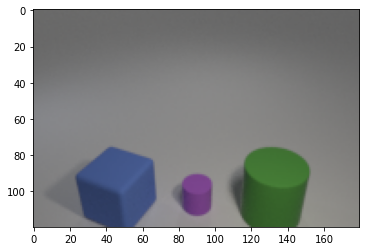

In [22]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img = trainset.__getitem__(1)["source_img_data"]
img_inv = unorm(img)
img_inv_t = np.einsum("ijk->jki",img_inv)
plt.imshow(img_inv_t)


In [38]:
state_dict = torch.load("best_rec_model.pth", map_location="cpu")#, map_location = "cpu")
rec_model.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
rec_model.

SyntaxError: invalid syntax (<ipython-input-39-beb376e8300b>, line 1)

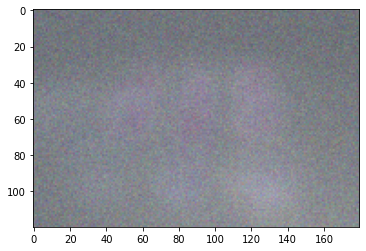

In [44]:
data =  trainset.generate_random_query_target()
img1 = np.stack([data['source_img_data'].cpu()])
#plt.subplot(1,2,1)
img1 = torch.from_numpy(img1).float()
img1 = torch.autograd.Variable(img1).cpu()#.cuda()
img2 = np.stack([data['target_img_data'].cpu()])
img2 = torch.from_numpy(img2).float()
img2 = torch.autograd.Variable(img2)#.cuda()
mods = [str(data['mod']['str'])]
mods = [t for t in mods]
rec_model = rec_model.to(torch.device("cpu"))
rec_model.eval()

img = rec_model.forward(img1,mods)
img_inv = unorm(img)

img_inv = img_inv.detach().numpy()[0]
img_inv = np.einsum("ijk->jki",img_inv)
plt.imshow(img_inv)

In [57]:
mods

['thêm khối cầu màu vàng']

In [59]:
rec_model.to(torch.device("cpu"))

TIRGReconstructionModel(
  (tirg_model): TIRG(
    (normalization_layer): NormalizationLayer()
    (soft_triplet_loss): TripletLoss()
    (img_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1):